# Development of Pre-processing Pipeline for Wet Lab Protocols

### Import Libraries For Preprocessing Pipeline

In [28]:
import stanza
from nltk import word_tokenize     # nltk library used for word tokenization
from nltk import tokenize
import re                          # re library used for Regular Expression Extraction
import nltk
import pandas as pd                # pandas used for Data Frames
import numpy as np                 # numpy used for array or matrix declaration                  
from os import walk                # os used for interacting with the operating system            
from nltk.corpus import stopwords  # stopwords of English language
import itertools
import unittest
import os
from unidecode import unidecode
import unicodedata2
import time
import string
from collections import defaultdict,Counter
import matplotlib.pyplot as plt    # plotting library for python 
import seaborn as sns              # data visualization library
%matplotlib inline

# Global Variables
global nlp 
nlp= stanza.Pipeline('en', processors={'tokenize':'spacy', 'pos':'spacy'}) # by default runs on gpus

2021-06-14 20:04:46 WARNING: Can not find pos: spacy from official model list. Ignoring it.
2021-06-14 20:04:46 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | spacy     |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-06-14 20:04:46 INFO: Use device: gpu
2021-06-14 20:04:46 INFO: Loading: tokenize
2021-06-14 20:04:46 INFO: Loading: pos
2021-06-14 20:04:47 INFO: Loading: lemma
2021-06-14 20:04:47 INFO: Loading: depparse
2021-06-14 20:04:48 INFO: Loading: sentiment
2021-06-14 20:04:49 INFO: Loading: ner
2021-06-14 20:04:50 INFO: Done loading processors!


In [16]:
stanza.download('en') # one time download

### Function for retrieving .ann file data

In [5]:
def retrieve_annfile_data(myfile_ann):
    
    ''' 1- function for extracting event based relation 'E#', general relations 'R#' along with entities from .ann file'''
    ''' 2- function for extracting Text-bounded Entities,their values, positions and types '''
    
    
    
    Event_relations_list=['Using','Using2','Using3','Using4','Acts-on','Acts-on2','Acts-on3','Acts-on4','Acts-on5','Site','Site2','Site3','Site4',
                         'Creates','Creates2','Count','Count2','Measure-Type-Link','Measure-Type-Link2']
    
    relation=''
    Scnd_entity=''
    event_dict={}
    e_id=[]
    e_data=[]
    text_bounded_dictionary={}
    
    df=pd.DataFrame(columns=['Event_ID','Main_Entity','Relation','Second_Entity'])
    fdf=pd.DataFrame(columns=['Relation_ID','Main_Entity','Relation','Second_Entity'])
 
    for line in myfile_ann:
        if line.startswith('T'):
            # 'Text_bounded Annotations if they are entity type( Object) like 'Reagent', 'Amount', 'Measure', 'time' etc
            # 'Also contain 'Action' as entity type if there is no location on which it(entity) acts-on'
            
            ann_ID, entity_type_Nrange, e_value= line.strip().split('\t')
            entity_type,e_start, e_end=entity_type_Nrange.split(" ")
            x=(entity_type,e_start,e_end,e_value)
            text_bounded_dictionary.update({ann_ID:x})
                    
        elif line.startswith('E'):
            if any(x in line for x in Event_relations_list):
                Event_ID,E_line=line.strip().split('\t')
                E_line=E_line.replace('Action:','')
                ent=E_line.split()
                Main_Entity=ent.pop(0)
                for i,entry in enumerate(ent):
                    outputs=entry.split(':')
                    relation=outputs[0]
                    relation=relation.rstrip(string.digits)
                    Scnd_entity=outputs[1]
                    df=df.append({'Event_ID': Event_ID,'Main_Entity':Main_Entity,'Relation':relation,'Second_Entity':Scnd_entity}
                            , ignore_index=True)
      
            else:
                
                ev_id,data=line.split('\t')
                data=data.replace('Action:', '') 
                data=data.rstrip()
                e_id.append(ev_id)
                e_data.append(data)
            event_dict = dict(zip(e_id, e_data))
   
                           
        elif line.startswith('R'):
            R_ID,R_line=line.strip().split('\t')
            R_line=re.sub(r"Arg\d:",'',R_line)
            relation,Main_Entity,Scnd_entity=R_line.split()
            relation=relation.rstrip(string.digits)
            fdf=fdf.append({'Relation_ID':R_ID,'Main_Entity':Main_Entity,'Relation':relation,'Second_Entity':Scnd_entity}
                            , ignore_index=True)
        else:
            pass
                           
    for key in event_dict:
        for index, item in fdf['Main_Entity'].items():
            if key==item:
                fdf['Main_Entity'][index]=event_dict[key]
               
    Events=df[df['Second_Entity'].str.match('E')]['Second_Entity'].tolist() #Events as second entity in df

    indexes=df.index[df['Second_Entity'].str.match('E')].tolist()  # indexes of above events in df


    listm=[]
    flat_list=[]
    for value in Events:
        a=df[df['Event_ID'] == value]['Main_Entity'].items
        listm.append(np.unique(a).tolist())
    
    # turn list of lists to flat-list
    for sublist in listm:
        for item in sublist:
            flat_list.append(item)
  
    for i,index in enumerate(indexes):
        df.iloc[index]['Second_Entity']=flat_list[i]
        
    keys1=df['Event_ID']
    values1=df['Main_Entity']
    event_dict1 = dict(zip(keys1, values1))
    for key in event_dict1:
        for index, item in fdf['Main_Entity'].items():
            if key==item:
                fdf['Main_Entity'][index]=event_dict1[key]    
            
    df=df.drop(columns=['Event_ID'])
    fdf=fdf.drop(columns=['Relation_ID'])
    frames = [df, fdf]
    Annotations_with_relation = pd.concat(frames,ignore_index=True)
    
    return Annotations_with_relation,text_bounded_dictionary

In [48]:
# function for finding sentence and their relevant/adjacent text bounded entities and also relation among those entities

def sentence_and_TBEntities(text_file,Annotations_with_relation,text_bound_entities_dictionary):
    
    '''1- function for finding sentence and their relevant/adjacent text bounded entities and also relation among those entities'''
    '''2- Replace annotation (T1 -> Reagent/Time,Method etc.) as well'''
    
    
    A=Annotations_with_relation # a dataframe
  
    dframe=pd.DataFrame(columns=['Sentence','Relevant_Annotations']) # initialize frame having each sentence and its annotation 
    keys=text_bound_entities_dictionary.keys()
    
    with open(text_file,'r',encoding='utf-8') as string_file:    # read .txt file
        start_index_of_every_line_wrt_doc_start=0
        for line in string_file:
            found_Annotation=[]
            end_index_of_every_line_wrt_doc_start=len(line)-1+start_index_of_every_line_wrt_doc_start
            for key in keys:
                if (int(text_bound_entities_dictionary[key][1])>=start_index_of_every_line_wrt_doc_start) and  (int(text_bound_entities_dictionary[key][2]) <=  end_index_of_every_line_wrt_doc_start):
                    found_Annotation.append(key) # extract all annotation present in each sentence         
            start_index_of_every_line_wrt_doc_start=end_index_of_every_line_wrt_doc_start+1
            dframe=dframe.append({'Sentence':line,'Relevant_Annotations':found_Annotation}, ignore_index=True) # dataframe having sentence and relevant annotations
    
    # create dataframe having sentence,relevant annotations, between relation, and annotation types too
    info_frame=pd.DataFrame(columns=['Sentence','Subj_Entity','Obj_Entity','relation','subj_type','obj_type','subj_start_end_indice', 'obj_start_end_indice' ])

    #Actual relation among entities
    for sen,lis in zip(dframe.Sentence,dframe.Relevant_Annotations):
        for a,b,r in zip(A.Main_Entity, A.Second_Entity, A.Relation):
            if ((a in lis) and (b in lis)):
                info_frame=info_frame.append({'Sentence':sen,'Subj_Entity':text_bound_entities_dictionary[a][3],'Obj_Entity':text_bound_entities_dictionary[b][3],'relation':r,
                                              'subj_type':text_bound_entities_dictionary[a][0] ,'obj_type': text_bound_entities_dictionary[b][0],
                                              'subj_start_end_indice':(text_bound_entities_dictionary[a][1],text_bound_entities_dictionary[a][2])  , 'obj_start_end_indice' :(text_bound_entities_dictionary[b][1],text_bound_entities_dictionary[b][2]) }, ignore_index=True)
                
    # 'no-relation' instances among entities   
    for sen,lis in zip(dframe.Sentence,dframe.Relevant_Annotations):
        for comb in list(itertools.combinations(lis, 2)):
            if ((A['Main_Entity']==comb[0]) & (A['Second_Entity']==comb[1])).any()==False:
                info_frame=info_frame.append({'Sentence':sen,'Subj_Entity':text_bound_entities_dictionary[comb[0]][3],
                                              'Obj_Entity':text_bound_entities_dictionary[comb[1]][3],'relation':'no-relation',
                                              'subj_type':text_bound_entities_dictionary[comb[0]][0] ,'obj_type':text_bound_entities_dictionary[comb[1]][0],
                                              'subj_start_end_indice':(text_bound_entities_dictionary[comb[0]][1],text_bound_entities_dictionary[comb[0]][2]) , 
                                              'obj_start_end_indice': (text_bound_entities_dictionary[comb[1]][1],text_bound_entities_dictionary[comb[1]][2]) }, ignore_index=True)
        
    return info_frame

In [49]:
def pattern_match_indices_finder(sentence,pattern):
    ''' function used to findout the indices of matched pattern/words in given sentence'''
    
    match_indices_list=[]
    for match in re.finditer(re.escape(pattern), sentence):
        s = match.start()
        e = match.end()
        match_indices_list.append((s,e))
    return match_indices_list


In [50]:
def find_combinations(list1,list2):
    ''' Generate a list of cominations from two lists'''
    all_combinations = []
    list1_permutations = itertools.permutations(list1, len(list2))
    for each_permutation in list1_permutations:
        zipped = zip(each_permutation, list2)
        all_combinations.append(list(zipped))
    open_list=[]
    for li in all_combinations:
        for ele in li:
            open_list.append(ele)
    open_list 

    return open_list


In [82]:
def Sub_Obj_position_finder(sentence, word, word_start_end):

    ''' function to find position of subject or object in given sentence  '''

    word_start_indice, word_end_indice=word_start_end #unpacking
    #sen_temp=sentence.replace(sentence[word_start_indice:word_end_indice],'ß')
    sen_temp="".join((sentence[:word_start_indice],"xyz",sentence[word_end_indice:]))
    #print(sen_temp)
    doc=nlp(unidecode(sen_temp))
    tokens=[token.text for sent in doc.sentences for token in sent.tokens] 
    for i,tok in enumerate(tokens):
        if 'xyz' in tok:
            position=i
            break
    doc1=nlp(unidecode(word))
    word_tokens=[token.text for sent in doc1.sentences for token in sent.tokens]
    token_len=len(word_tokens)
    word_start= position
    word_end=position+token_len-1
    
    
    return word_start,word_end
    
    

In [83]:
def AnnotationPositions(info_frame, dictionary, txt_file):
    
    ''' function for finding subject and object annotations positions in sentence'''
    
    # adding new empty coloumns to dataframe
    info_frame['subj_start']=""           
    info_frame['subj_end']=""
    info_frame['obj_start']=""
    info_frame['obj_end']=""
    
    #.txt file reading 
    protocol_txt_file=open(txt_file,'r',encoding='utf-8')
    prtcl=protocol_txt_file.read()  # reading protocl txt file
    
    # Actual Process
    for index,sen,subj,obj,sub_se,obj_se in zip(info_frame.index,info_frame.Sentence, info_frame.Subj_Entity,info_frame.Obj_Entity, 
                   info_frame.subj_start_end_indice, info_frame.obj_start_end_indice):
    
        # Actual values of subject and object indices wrt .txt file and taken from .ann file
        sub_s,sub_e=sub_se
        obj_s,obj_e=obj_se
        distance_actual=abs(int(sub_e)-int(obj_s))
        
        # Sentence based values of subj and obj 
        sub_list= pattern_match_indices_finder(sen,subj)
        obj_list=pattern_match_indices_finder(sen,obj)
    
        # if we have more than one matches then we need to find more than one distances to confirm sub,obj positions
        if len(sub_list)>len(obj_list):
            for i in range(len(sub_list)-len(obj_list)):
                           obj_list.append((0,0))
        elif (len(sub_list)<len(obj_list)):
            for i in range(len(obj_list)-len(sub_list)):
                sub_list.append((0,0))
        else:
            pass

        distance_indices_frame=pd.DataFrame(columns=['distance','subj_tuple','obj_tuple'])
        combinations=find_combinations(sub_list,obj_list)

        for t1,t2 in combinations:
            dis=abs((t1[1])-(t2[0]))
            if (dis==distance_actual) or (abs(dis-distance_actual)==1):
                subj_start_end=t1
                obj_start_end=t2
                break
    
        # Find positions
        subj_start,subj_end= Sub_Obj_position_finder(sen, subj, subj_start_end)  # call for subjects positions
        obj_start,obj_end= Sub_Obj_position_finder(sen, obj, obj_start_end)   # call for objects positions
        
                
        # Insert positions in dataframe
        info_frame.at[index, 'subj_start'] = subj_start
        info_frame.at[index, 'subj_end'] = subj_end
        info_frame.at[index, 'obj_start'] = obj_start
        info_frame.at[index, 'obj_end'] = obj_end
    
    info_frame=info_frame.drop(['subj_start_end_indice', 'obj_start_end_indice'], axis = 1) # drop coloumns of no use further 
    protocol_txt_file.close()    
       
    return info_frame

In [117]:
def ner_tags(info_frame):
    
    '''fuction for tokenization and ner of sentences'''
    
    info_frame['token']=""  
    info_frame['stanford_ner']=""  
    
    for index,sentence,subj,obj,s_type,o_type,ss,se,os,oe in zip(info_frame.index,info_frame.Sentence,info_frame.Subj_Entity,info_frame.Obj_Entity,info_frame.subj_type, info_frame.obj_type,info_frame.subj_start, info_frame.subj_end,
                       info_frame.obj_start,info_frame.obj_end):
        ner=[]
        #print(subj,obj,sentence)
        #print(ss,se,os,oe)
        sentence=sentence.rstrip()
        doc=nlp(unidecode(sentence))  # initialize stanza pipeline for every new sentence
        token=[word.text for sent in doc.sentences for word in sent.words]
        #print(token)
    
        
    
        info_frame.at[index, 'token'] = token #Insert tokens in dataframe
        sub_type_list=[]    
        obj_type_list=[]
        
        subject_range_list=list(range(ss,se+1))
        sub_type_list.append(s_type)
        
        object_range_list=list(range(os,oe+1))
        obj_type_list.append(o_type)
        
        sub_list=find_combinations(subject_range_list,sub_type_list)
        obj_list=find_combinations(object_range_list,obj_type_list)
        type_index_list=sub_list + obj_list
        #print('type_index_list ', type_index_list)
        
    # NER tagging
        empty_list=['O' for _ in range(len(token))]
        for element in type_index_list:
            empty_list[element[0]]=element[1]
        ner= empty_list
    
        info_frame.at[index, 'stanford_ner'] = ner #Insert list features in dataframe
        
        
    return info_frame   
    

In [118]:
def List_Features(info_frame):
    
    ''' function for finding sentence Part-of-Speech(pos), their named entity tags(ner) '''
    ''' their dependency heads(standford_heads according to standford parser), their dependency tree roles/relations(deprel)'''
    
    #Adding new coloumns to dataframe           
    info_frame['stanford_pos']=""
    info_frame['stanford_head']=""
    info_frame['stanford_deprel']=""   
    for index,sentence,s_type,o_type,ss,se,os,oe in zip(info_frame.index,info_frame.Sentence,info_frame.subj_type, info_frame.obj_type,info_frame.subj_start, info_frame.subj_end,
                       info_frame.obj_start,info_frame.obj_end):
        sentence=sentence.rstrip()
        doc=nlp(unidecode(sentence))  # initialize stanza pipeline for every new sentence        
        pos=[word.xpos for sent in doc.sentences for word in sent.words]     # Part-of-Speech Tagging
        heads=[word.head for sent in doc.sentences for word in sent.words] # Stanford_dependency heads
        deprel=[word.deprel for sent in doc.sentences for word in sent.words]        # relations with heads
        info_frame.at[index, 'stanford_pos'] = pos #Insert list features in dataframe
        info_frame.at[index, 'stanford_head'] = heads #Insert list features in dataframe
        info_frame.at[index, 'stanford_deprel'] = deprel #Insert list features in dataframe
        
        
    return info_frame

In [119]:
def Features_Extraction(ann_file,txt_file):    # ann_file as annotation file, txt_file as .txt file, Brat Standoff Format
    
    ''' Fuction to assemble featues into dataframe'''

    protocol_ann_file=open(ann_file,'r',encoding='utf-8')
    protocol_txt_file=open(txt_file,'r',encoding='utf-8')
    # assign a doc_id to file from which the examples are drawn
    docid, ext = os.path.splitext(ann_file)
    #.ann file reading, Three annotation types, 1- Object based entity, 2-Event_based_Entity, 3- Relation
    Annotations_with_relation, dictionary=retrieve_annfile_data(protocol_ann_file)
    relations_frame= sentence_and_TBEntities(txt_file,Annotations_with_relation,dictionary)
    info_frame=AnnotationPositions(relations_frame,dictionary,txt_file )
    info_frame['docid']=""   # Add new empty coloumn docid
    info_frame['id']=""      # Add new empty coloumn id
    
    info_frame['id']= info_frame.Sentence.map(hash)
    info_frame['docid']=docid
    
    Updated_frame=List_Features(info_frame)
    feature_frame=ner_tags(Updated_frame)

    protocol_ann_file.close()
    protocol_txt_file.close()

    return feature_frame  

In [120]:
def DataSet_Features_Extraction(data_path):
    ''' function to extract data from all files in Dataset and assemble them in One dataframe/required format'''
    collected_frame=pd.DataFrame()   # initialize empty dataframe
    EXTENSIONS = {'.txt', '.ann'}
    grouped_files = defaultdict(int)
    for f in os.listdir(data_path):
        name, ext = os.path.splitext(os.path.join(data_path, f))
        if ext in EXTENSIONS:
            grouped_files[name] += 1
    for name in grouped_files:
        if grouped_files[name] == len(EXTENSIONS):
            txt_file_name=name + '.txt'
            ann_file_name=name + '.ann'
            print(txt_file_name,ann_file_name)
            individual_frame=Features_Extraction(ann_file_name,txt_file_name) #Call Features_Extraction function and then assemble data of every call into big frame
            collected_frame=pd.concat([individual_frame,collected_frame])     # Concatenate dataframes of each file
    collected_frame=collected_frame.drop(['Sentence' ], axis=1)
        
    return collected_frame    
    

In [114]:
def dataframe_jsonFile(d_Frame,path_name):
    
    ''' function to create json file from dataframe'''
    
    folder=os.path.basename(os.path.normpath(path_name))
    cols=list(d_Frame.columns.values)   # columns of dataframe
    cols=['id','docid','relation','token','subj_start','subj_end','obj_start','obj_end','subj_type','obj_type','stanford_pos','stanford_ner','stanford_head',
    'stanford_deprel']   # set positions of coloumns
    d_Frame=d_Frame[cols]
    d_Frame.reset_index(drop=True, inplace=True)     # reset index of dataframe
    json_file=d_Frame.to_json("{}.json".format(folder),orient = "records")
    
    
    return json_file
    
    

### Path to Dataset

In [102]:
train_data='WLP-Dataset-master_updated/train/'
dev_data='WLP-Dataset-master_updated/dev/'
test_data='WLP-Dataset-master_updated/test/'

## Main Function( Pre-processing)

In [103]:
train_frame=DataSet_Features_Extraction(train_data)  # Generate dataframe for train data


WLP-Dataset-master_updated/train/protocol_309.txt WLP-Dataset-master_updated/train/protocol_309.ann
WLP-Dataset-master_updated/train/protocol_59.txt WLP-Dataset-master_updated/train/protocol_59.ann
WLP-Dataset-master_updated/train/protocol_190.txt WLP-Dataset-master_updated/train/protocol_190.ann
WLP-Dataset-master_updated/train/protocol_311.txt WLP-Dataset-master_updated/train/protocol_311.ann
WLP-Dataset-master_updated/train/protocol_38.txt WLP-Dataset-master_updated/train/protocol_38.ann
WLP-Dataset-master_updated/train/protocol_417.txt WLP-Dataset-master_updated/train/protocol_417.ann
WLP-Dataset-master_updated/train/protocol_14.txt WLP-Dataset-master_updated/train/protocol_14.ann
WLP-Dataset-master_updated/train/protocol_478.txt WLP-Dataset-master_updated/train/protocol_478.ann
WLP-Dataset-master_updated/train/protocol_274.txt WLP-Dataset-master_updated/train/protocol_274.ann
WLP-Dataset-master_updated/train/protocol_479.txt WLP-Dataset-master_updated/train/protocol_479.ann
WLP-Da

WLP-Dataset-master_updated/train/protocol_317.txt WLP-Dataset-master_updated/train/protocol_317.ann
WLP-Dataset-master_updated/train/protocol_99.txt WLP-Dataset-master_updated/train/protocol_99.ann
WLP-Dataset-master_updated/train/protocol_407.txt WLP-Dataset-master_updated/train/protocol_407.ann
WLP-Dataset-master_updated/train/protocol_67.txt WLP-Dataset-master_updated/train/protocol_67.ann
WLP-Dataset-master_updated/train/protocol_410.txt WLP-Dataset-master_updated/train/protocol_410.ann
WLP-Dataset-master_updated/train/protocol_39.txt WLP-Dataset-master_updated/train/protocol_39.ann
WLP-Dataset-master_updated/train/protocol_316.txt WLP-Dataset-master_updated/train/protocol_316.ann
WLP-Dataset-master_updated/train/protocol_492.txt WLP-Dataset-master_updated/train/protocol_492.ann
WLP-Dataset-master_updated/train/protocol_75.txt WLP-Dataset-master_updated/train/protocol_75.ann
WLP-Dataset-master_updated/train/protocol_262.txt WLP-Dataset-master_updated/train/protocol_262.ann
WLP-Data

WLP-Dataset-master_updated/train/protocol_3.txt WLP-Dataset-master_updated/train/protocol_3.ann
WLP-Dataset-master_updated/train/protocol_392.txt WLP-Dataset-master_updated/train/protocol_392.ann
WLP-Dataset-master_updated/train/protocol_25.txt WLP-Dataset-master_updated/train/protocol_25.ann
WLP-Dataset-master_updated/train/protocol_412.txt WLP-Dataset-master_updated/train/protocol_412.ann
WLP-Dataset-master_updated/train/protocol_338.txt WLP-Dataset-master_updated/train/protocol_338.ann
WLP-Dataset-master_updated/train/protocol_175.txt WLP-Dataset-master_updated/train/protocol_175.ann
WLP-Dataset-master_updated/train/protocol_419.txt WLP-Dataset-master_updated/train/protocol_419.ann
WLP-Dataset-master_updated/train/protocol_64.txt WLP-Dataset-master_updated/train/protocol_64.ann
WLP-Dataset-master_updated/train/protocol_505.txt WLP-Dataset-master_updated/train/protocol_505.ann
WLP-Dataset-master_updated/train/protocol_497.txt WLP-Dataset-master_updated/train/protocol_497.ann
WLP-Data

WLP-Dataset-master_updated/train/protocol_120.txt WLP-Dataset-master_updated/train/protocol_120.ann
WLP-Dataset-master_updated/train/protocol_201.txt WLP-Dataset-master_updated/train/protocol_201.ann
WLP-Dataset-master_updated/train/protocol_415.txt WLP-Dataset-master_updated/train/protocol_415.ann
WLP-Dataset-master_updated/train/protocol_150.txt WLP-Dataset-master_updated/train/protocol_150.ann
WLP-Dataset-master_updated/train/protocol_133.txt WLP-Dataset-master_updated/train/protocol_133.ann
WLP-Dataset-master_updated/train/protocol_400.txt WLP-Dataset-master_updated/train/protocol_400.ann
WLP-Dataset-master_updated/train/protocol_91.txt WLP-Dataset-master_updated/train/protocol_91.ann
WLP-Dataset-master_updated/train/protocol_482.txt WLP-Dataset-master_updated/train/protocol_482.ann
WLP-Dataset-master_updated/train/protocol_298.txt WLP-Dataset-master_updated/train/protocol_298.ann
WLP-Dataset-master_updated/train/protocol_136.txt WLP-Dataset-master_updated/train/protocol_136.ann
WL

WLP-Dataset-master_updated/train/protocol_588.txt WLP-Dataset-master_updated/train/protocol_588.ann
WLP-Dataset-master_updated/train/protocol_601.txt WLP-Dataset-master_updated/train/protocol_601.ann
WLP-Dataset-master_updated/train/protocol_269.txt WLP-Dataset-master_updated/train/protocol_269.ann
WLP-Dataset-master_updated/train/protocol_37.txt WLP-Dataset-master_updated/train/protocol_37.ann
WLP-Dataset-master_updated/train/protocol_581.txt WLP-Dataset-master_updated/train/protocol_581.ann
WLP-Dataset-master_updated/train/protocol_252.txt WLP-Dataset-master_updated/train/protocol_252.ann
WLP-Dataset-master_updated/train/protocol_286.txt WLP-Dataset-master_updated/train/protocol_286.ann
WLP-Dataset-master_updated/train/protocol_347.txt WLP-Dataset-master_updated/train/protocol_347.ann
WLP-Dataset-master_updated/train/protocol_217.txt WLP-Dataset-master_updated/train/protocol_217.ann
WLP-Dataset-master_updated/train/protocol_205.txt WLP-Dataset-master_updated/train/protocol_205.ann


In [106]:
dataframe_jsonFile(train_frame,train_data)   # create train.json file
train_frame

,Subj_Entity,Obj_Entity,relation,subj_type,obj_type,subj_start,subj_end,obj_start,obj_end,docid,id,stanford_pos,stanford_head,stanford_deprel,token,stanford_ner
0,Soak,PVDF membrane,Acts-on,Action,Reagent,0,0,2,3,WLP-Dataset-master_updated/train/protocol_205,109627235236557200,"[VB, DT, NN, NN, IN, CD, NN, NN, IN, CD, SYM, ...","[0, 4, 4, 1, 8, 7, 8, 1, 13, 13, 12, 10, 1, 15...","[root, det, compound, obj, case, nummod, compo...","[Soak, the, PVDF, membrane, in, 100, %, methan...","[Action, O, Reagent, Reagent, O, O, O, O, O, O..."
1,Soak,methanol,Site,Action,Reagent,0,0,7,7,WLP-Dataset-master_updated/train/protocol_205,109627235236557200,"[VB, DT, NN, NN, IN, CD, NN, NN, IN, CD, SYM, ...","[0, 4, 4, 1, 8, 7, 8, 1, 13, 13, 12, 10, 1, 15...","[root, det, compound, obj, case, nummod, compo...","[Soak, the, PVDF, membrane, in, 100, %, methan...","[Action, O, O, O, O, O, O, Reagent, O, O, O, O..."
2,rinse,2‐3 times,Count,Action,Numerical,14,14,15,18,WLP-Dataset-master_updated/train/protocol_205,109627235236557200,"[VB, DT, NN, NN, IN, CD, NN, NN, IN, CD, SYM, ...","[0, 4, 4, 1, 8, 7, 8, 1, 13, 13, 12, 10, 1, 15...","[root, det, compound, obj, case, nummod, compo...","[Soak, the, PVDF, membrane, in, 100, %, methan...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, Act..."
3,rinse,deionized water,Using,Action,Reagent,14,14,20,21,WLP-Dataset-master_updated/train/protocol_205,109627235236557200,"[VB, DT, NN, NN, IN, CD, NN, NN, IN, CD, SYM, ...","[0, 4, 4, 1, 8, 7, 8, 1, 13, 13, 12, 10, 1, 15...","[root, det, compound, obj, case, nummod, compo...","[Soak, the, PVDF, membrane, in, 100, %, methan...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, Act..."
4,rinse,PVDF membrane,Acts-on,Action,Reagent,14,14,2,3,WLP-Dataset-master_updated/train/protocol_205,109627235236557200,"[VB, DT, NN, NN, IN, CD, NN, NN, IN, CD, SYM, ...","[0, 4, 4, 1, 8, 7, 8, 1, 13, 13, 12, 10, 1, 15...","[root, det, compound, obj, case, nummod, compo...","[Soak, the, PVDF, membrane, in, 100, %, methan...","[O, O, Reagent, Reagent, O, O, O, O, O, O, O, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,sample tube,carbon fiber tube,no-relation,Location,Location,2,3,6,8,WLP-Dataset-master_updated/train/protocol_309,7930655643126231905,"[VB, DT, NN, NN, IN, DT, NN, NN, NN, .]","[0, 4, 4, 1, 9, 9, 8, 9, 1, 1]","[root, det, compound, obj, case, det, compound...","[Slide, the, sample, tube, into, the, carbon, ...","[O, O, Location, Location, O, O, Location, Loc..."
99,shrink,carbon fiber,no-relation,Action,Location,2,2,16,17,WLP-Dataset-master_updated/train/protocol_309,-7379392635185759246,"[RB, ,, VB, IN, JJ, CC, JJ, NN, HYPH, NNS, IN,...","[3, 1, 0, 10, 10, 7, 5, 10, 10, 3, 14, 14, 14,...","[advmod, punct, root, case, amod, cc, conj, co...","[Similarly, ,, shrink, on, inner, and, middle,...","[O, O, Action, O, O, O, O, O, O, O, O, O, O, O..."
100,sample tube,carbon fiber,no-relation,Location,Location,12,13,16,17,WLP-Dataset-master_updated/train/protocol_309,-7379392635185759246,"[RB, ,, VB, IN, JJ, CC, JJ, NN, HYPH, NNS, IN,...","[3, 1, 0, 10, 10, 7, 5, 10, 10, 3, 14, 14, 14,...","[advmod, punct, root, case, amod, cc, conj, co...","[Similarly, ,, shrink, on, inner, and, middle,...","[O, O, O, O, O, O, O, O, O, O, O, O, Location,..."
101,sample tube,nner and middle end-caps,no-relation,Location,Location,12,13,4,9,WLP-Dataset-master_updated/train/protocol_309,-7379392635185759246,"[RB, ,, VB, IN, JJ, CC, JJ, NN, HYPH, NNS, IN,...","[3, 1, 0, 10, 10, 7, 5, 10, 10, 3, 14, 14, 14,...","[advmod, punct, root, case, amod, cc, conj, co...","[Similarly, ,, shrink, on, inner, and, middle,...","[O, O, O, O, Location, Location, Location, Loc..."


In [121]:
dev_frame=DataSet_Features_Extraction(dev_data)    # Generate dataframe for development data


WLP-Dataset-master_updated/dev/protocol_270.txt WLP-Dataset-master_updated/dev/protocol_270.ann
WLP-Dataset-master_updated/dev/protocol_36.txt WLP-Dataset-master_updated/dev/protocol_36.ann
WLP-Dataset-master_updated/dev/protocol_129.txt WLP-Dataset-master_updated/dev/protocol_129.ann
WLP-Dataset-master_updated/dev/protocol_312.txt WLP-Dataset-master_updated/dev/protocol_312.ann
WLP-Dataset-master_updated/dev/protocol_395.txt WLP-Dataset-master_updated/dev/protocol_395.ann
WLP-Dataset-master_updated/dev/protocol_586.txt WLP-Dataset-master_updated/dev/protocol_586.ann
WLP-Dataset-master_updated/dev/protocol_81.txt WLP-Dataset-master_updated/dev/protocol_81.ann
WLP-Dataset-master_updated/dev/protocol_174.txt WLP-Dataset-master_updated/dev/protocol_174.ann
WLP-Dataset-master_updated/dev/protocol_532.txt WLP-Dataset-master_updated/dev/protocol_532.ann
WLP-Dataset-master_updated/dev/protocol_61.txt WLP-Dataset-master_updated/dev/protocol_61.ann
WLP-Dataset-master_updated/dev/protocol_172.tx

WLP-Dataset-master_updated/dev/protocol_604.txt WLP-Dataset-master_updated/dev/protocol_604.ann
WLP-Dataset-master_updated/dev/protocol_584.txt WLP-Dataset-master_updated/dev/protocol_584.ann
WLP-Dataset-master_updated/dev/protocol_524.txt WLP-Dataset-master_updated/dev/protocol_524.ann
WLP-Dataset-master_updated/dev/protocol_593.txt WLP-Dataset-master_updated/dev/protocol_593.ann
WLP-Dataset-master_updated/dev/protocol_260.txt WLP-Dataset-master_updated/dev/protocol_260.ann
WLP-Dataset-master_updated/dev/protocol_250.txt WLP-Dataset-master_updated/dev/protocol_250.ann
WLP-Dataset-master_updated/dev/protocol_431.txt WLP-Dataset-master_updated/dev/protocol_431.ann
WLP-Dataset-master_updated/dev/protocol_442.txt WLP-Dataset-master_updated/dev/protocol_442.ann
WLP-Dataset-master_updated/dev/protocol_353.txt WLP-Dataset-master_updated/dev/protocol_353.ann
WLP-Dataset-master_updated/dev/protocol_377.txt WLP-Dataset-master_updated/dev/protocol_377.ann
WLP-Dataset-master_updated/dev/protocol_

In [122]:
test_frame=DataSet_Features_Extraction(test_data)   # Generate dataframe for test data

WLP-Dataset-master_updated/test/protocol_473.txt WLP-Dataset-master_updated/test/protocol_473.ann
WLP-Dataset-master_updated/test/protocol_59.txt WLP-Dataset-master_updated/test/protocol_59.ann
WLP-Dataset-master_updated/test/protocol_132.txt WLP-Dataset-master_updated/test/protocol_132.ann
WLP-Dataset-master_updated/test/protocol_345.txt WLP-Dataset-master_updated/test/protocol_345.ann
WLP-Dataset-master_updated/test/protocol_376.txt WLP-Dataset-master_updated/test/protocol_376.ann
WLP-Dataset-master_updated/test/protocol_397.txt WLP-Dataset-master_updated/test/protocol_397.ann
WLP-Dataset-master_updated/test/protocol_496.txt WLP-Dataset-master_updated/test/protocol_496.ann
WLP-Dataset-master_updated/test/protocol_254.txt WLP-Dataset-master_updated/test/protocol_254.ann
WLP-Dataset-master_updated/test/protocol_238.txt WLP-Dataset-master_updated/test/protocol_238.ann
WLP-Dataset-master_updated/test/protocol_122.txt WLP-Dataset-master_updated/test/protocol_122.ann
WLP-Dataset-master_upd

WLP-Dataset-master_updated/test/protocol_288.txt WLP-Dataset-master_updated/test/protocol_288.ann
WLP-Dataset-master_updated/test/protocol_608.txt WLP-Dataset-master_updated/test/protocol_608.ann
WLP-Dataset-master_updated/test/protocol_228.txt WLP-Dataset-master_updated/test/protocol_228.ann
WLP-Dataset-master_updated/test/protocol_589.txt WLP-Dataset-master_updated/test/protocol_589.ann
WLP-Dataset-master_updated/test/protocol_49.txt WLP-Dataset-master_updated/test/protocol_49.ann
WLP-Dataset-master_updated/test/protocol_380.txt WLP-Dataset-master_updated/test/protocol_380.ann
WLP-Dataset-master_updated/test/protocol_176.txt WLP-Dataset-master_updated/test/protocol_176.ann
WLP-Dataset-master_updated/test/protocol_511.txt WLP-Dataset-master_updated/test/protocol_511.ann
WLP-Dataset-master_updated/test/protocol_399.txt WLP-Dataset-master_updated/test/protocol_399.ann
WLP-Dataset-master_updated/test/protocol_173.txt WLP-Dataset-master_updated/test/protocol_173.ann
WLP-Dataset-master_upd

In [123]:
dataframe_jsonFile(dev_frame,dev_data)       # create dev.json file
dataframe_jsonFile(test_frame,test_data)      # create test.json file

# Train Data Important Statistics

In [124]:
train_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92878 entries, 0 to 102
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Subj_Entity      92878 non-null  object
 1   Obj_Entity       92878 non-null  object
 2   relation         92878 non-null  object
 3   subj_type        92878 non-null  object
 4   obj_type         92878 non-null  object
 5   subj_start       92878 non-null  object
 6   subj_end         92878 non-null  object
 7   obj_start        92878 non-null  object
 8   obj_end          92878 non-null  object
 9   docid            92878 non-null  object
 10  id               92878 non-null  int64 
 11  stanford_pos     92878 non-null  object
 12  stanford_head    92878 non-null  object
 13  stanford_deprel  92878 non-null  object
 14  token            92878 non-null  object
 15  stanford_ner     92878 non-null  object
dtypes: int64(1), object(15)
memory usage: 12.0+ MB


/home/hz071/.conda/envs/GPU_pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


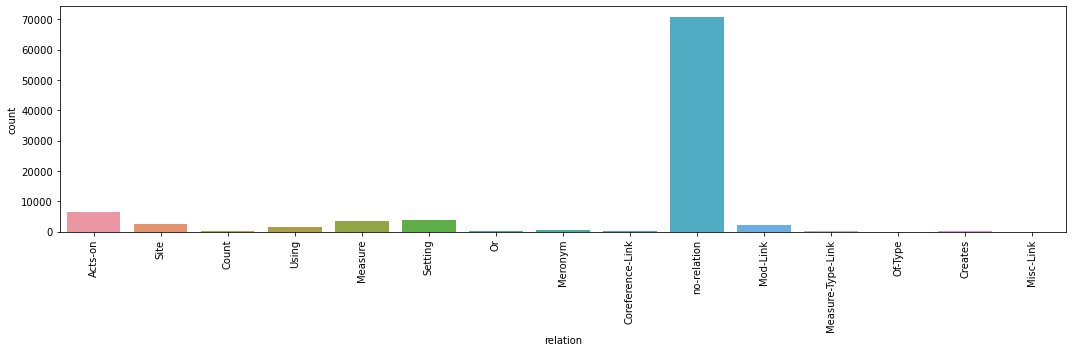

In [125]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('relation', data=train_frame)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Relation types Count

/home/hz071/.conda/envs/GPU_pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


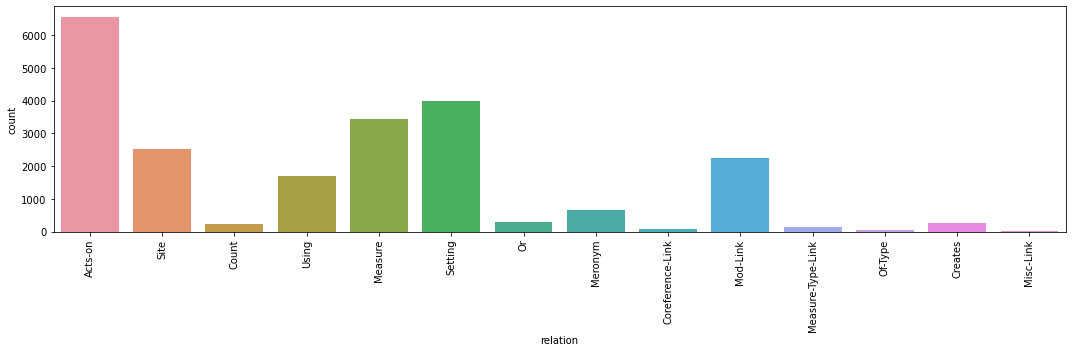

In [126]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('relation', data=train_frame.loc[train_frame['relation'] != 'no-relation'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

## Entities Type Count

/home/hz071/.conda/envs/GPU_pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


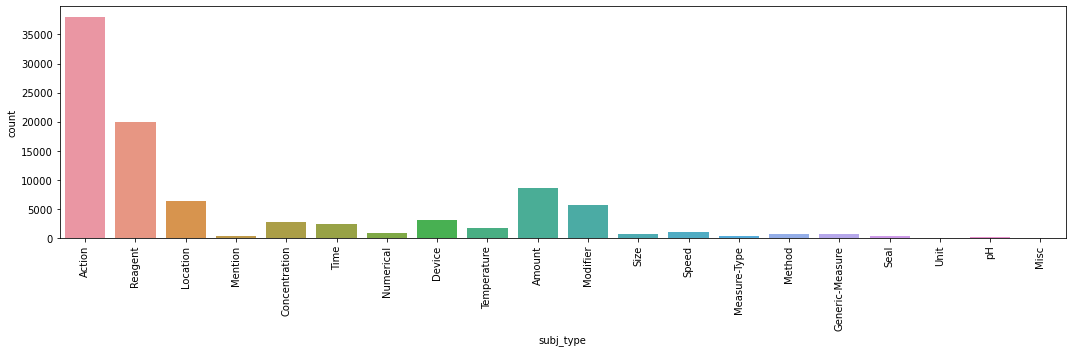

In [127]:
# As a Subject Entities types count
plt.figure(figsize=(15, 5))
ax = sns.countplot('subj_type', data=train_frame)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

/home/hz071/.conda/envs/GPU_pytorch/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


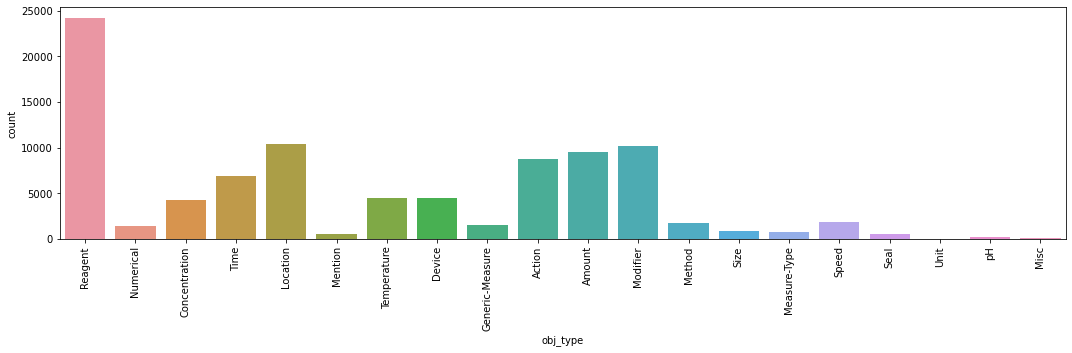

In [128]:
# As a Object Entities types count
plt.figure(figsize=(15, 5))
ax = sns.countplot('obj_type', data=train_frame)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

### Types of Relations in use

In [129]:
train_frame['relation'].groupby(list(train_frame.relation)).count()

Acts-on               6544
Coreference-Link        80
Count                  243
Creates                277
Measure               3433
Measure-Type-Link      142
Meronym                673
Misc-Link               13
Mod-Link              2236
Of-Type                 43
Or                     287
Setting               3971
Site                  2522
Using                 1687
no-relation          70727
Name: relation, dtype: int64

### Types of POS tags being used 

In [134]:
long_pos_list=[]
for lis in train_frame.stanford_pos:
    for ele in lis:
        long_pos_list.append(ele)
        
pos_types=Counter(long_pos_list) 
print(len(pos_types))
print(pos_types)

50
Counter({'NN': 595762, 'IN': 272315, 'CD': 199141, 'VB': 151259, 'DT': 142194, 'NNS': 108471, '.': 88862, ',': 84940, 'JJ': 81520, 'CC': 68521, 'RB': 45016, 'VBN': 42017, '-RRB-': 41182, 'NNP': 39142, '-LRB-': 37952, 'VBG': 30488, 'HYPH': 21822, 'SYM': 21184, 'TO': 19845, 'FW': 12988, ':': 12312, 'RP': 10923, 'VBZ': 7512, 'PRP': 6966, 'VBP': 4103, 'VBD': 3322, 'MD': 3108, 'RBS': 2463, 'PRP$': 2271, 'POS': 2029, 'JJR': 1955, "''": 1619, '``': 1523, 'WDT': 1272, 'WRB': 1031, 'NFP': 756, 'UH': 708, 'LS': 648, 'NNPS': 562, 'JJS': 391, '$': 258, 'EX': 255, 'PDT': 233, 'RBR': 162, 'AFX': 147, '-RSB-': 126, '-LSB-': 78, 'ADD': 51, 'GW': 11, 'WP': 6})


### Types of NER tags being used 

In [133]:
long_ner_list=[]
for lis in train_frame.stanford_ner:
    for ele in lis:
        long_ner_list.append(ele)
        
ner_count=Counter(long_ner_list)
print(len(ner_count))
print(ner_count)

21
Counter({'O': 1873479, 'Reagent': 81146, 'Action': 50436, 'Amount': 31534, 'Location': 27265, 'Modifier': 20617, 'Time': 19794, 'Concentration': 14014, 'Device': 13740, 'Temperature': 9314, 'Speed': 6523, 'Method': 6103, 'Generic-Measure': 5661, 'Size': 3385, 'Numerical': 3114, 'Measure-Type': 1673, 'Seal': 1557, 'Mention': 902, 'pH': 670, 'Misc': 485, 'Unit': 10})


### Types of deprel tags being used 

In [135]:
long_deprel_list=[]
for lis in train_frame.stanford_deprel:
    for ele in lis:
        long_deprel_list.append(ele)
        
deprel_count=Counter(long_deprel_list)  
print(len(deprel_count))
print(deprel_count)

45
Counter({'punct': 287397, 'case': 275497, 'compound': 234480, 'nummod': 162496, 'obl': 147301, 'obj': 142660, 'det': 139917, 'nmod': 122050, 'amod': 101612, 'conj': 101384, 'root': 95932, 'cc': 73355, 'appos': 49605, 'advmod': 43447, 'mark': 40033, 'advcl': 37913, 'parataxis': 15085, 'acl': 14126, 'flat': 12650, 'nsubj': 10676, 'compound:prt': 10391, 'aux:pass': 8194, 'xcomp': 7563, 'nsubj:pass': 7313, 'aux': 5179, 'nmod:poss': 4068, 'obl:tmod': 3782, 'cop': 3651, 'obl:npmod': 3602, 'fixed': 1695, 'list': 1645, 'ccomp': 1552, 'acl:relcl': 1463, 'dep': 783, 'nmod:npmod': 581, 'cc:preconj': 534, 'discourse': 440, 'nmod:tmod': 283, 'expl': 271, 'iobj': 234, 'det:predet': 233, 'csubj': 195, 'orphan': 111, 'vocative': 32, 'goeswith': 11})
